# Problem 4.1

In [1]:
'''
Things to note:

- Now we are using the skorch library which allows us to do parameter tunning in the same way as for
other classifiers in sklearn. 
- The code to add L1 regularization is already implemented.

'''

'\nThings to note:\n\n- Now we are using the skorch library which allows us to do parameter tunning in the same way as for\nother classifiers in sklearn. \n- The code to add L1 regularization is already implemented.\n\n'

In [2]:
'''
Import packages 
'''

%matplotlib inline

from sklearn.datasets import fetch_openml # Import MNIST from a Package
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Standard PyTorch Imports
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# We will be using the PyTorch Wrapper Framework skorch to help simplify the coding
from skorch import NeuralNetClassifier

# We need to import some Sci-kit Learn modules for computation purposes.``
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

# Global Settings - These settings are critical

# If CUDA is available, use CUDA or else default to CPU.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Setting a seed for torch
torch.manual_seed(0)


C:\Users\seanr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
'''
Import the data
'''
# select the root = ....

mnist = torchvision.datasets.MNIST(
    root = './data', 
    train = True, 
    transform = transforms.ToTensor(),  
    download = True
)

test_dataset = torchvision.datasets.MNIST(
    root = './data', 
    train = False, 
    transform = transforms.ToTensor()
)


X_train = mnist.data
y_train = mnist.targets

X_test = test_dataset.data
y_test = test_dataset.targets


'''
Step -- Normalize each input from [0.0,1.0] range
'''

X_train = X_train / 255
X_test = X_test / 255

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)


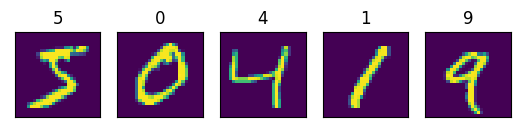

In [4]:

'''
Will do some basic plotting to get a feel for the data that we imported.

'''

def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y.item())
        
plot_example(X_train, y_train)

In [5]:
# build your CNN 

class CNN(nn.Module):
    def __init__(self, dropout = 0.4):
        super(CNN, self).__init__()
        '''Step -- Fill in the architecture'''
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.pool2 = nn.MaxPool2d(2, stride=2)

        # Fully-connected layers
        # Having 3 layers here is probably not totally necessary 
        # But going from 512 -> 128 -> 10 seemed like a big jump
        # so first halfing it felt a little more reasonable
        self.fc1 = nn.Linear(512, 256)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):
        '''Step -- Fill in the Forward propagation function'''      
        output = torch.relu(self.conv1(x))
        output = self.pool1(output)
        output = torch.relu(self.conv2(output))
        output = self.pool2(output)

        output = output.reshape(-1, 512)
        output = torch.relu(self.fc1(output))
        # Dropout is only actually applied after the first
        # layer of the full-connected step. Would it be better
        # to apply it to each layer? Honestly not sure
        # I got good values without modyfing this, so I'm leaving it
        output = self.drop(output)
        output = torch.relu(self.fc2(output))
        output = self.fc3(output)
        output = torch.softmax(output, 1)
        return output


In [6]:
# Adding L1 regularization

class RegularizedNet(NeuralNetClassifier):
    
    ''''''
    
    def __init__(self, *args, lambda1 = 0.01, **kwargs):
        super().__init__(*args, **kwargs)
        self.lambda1 = lambda1
    
    ''' *** Explain -- What is the following method doing? Explain in detail in the main pdf ***'''
    
    def get_loss(self, y_pred, y_true, X = None, training = False):
        loss = super().get_loss(y_pred, y_true, X = X, training = training)
        loss += self.lambda1 * sum([w.abs().sum() for w in self.module_.parameters()])
        return loss

In [7]:
# print out the structure of the model 
cnn = CNN()
print(cnn)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (drop): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [8]:
'''
Check Device == 'cuda'. USE GPU !!!!. Otherwise things will be super slow. Check
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d 
'''

print('Using Device = ',device)

Using Device =  cuda


In [9]:
'''
Here we define the RegularizedNet. Make sure you use nn.NLLLoss. Thus, you have to use a correct last activation
in the forward method of your network

We can specify different parameters such as learning rate (lr), our optimizar (start with standard SGD, in 4.3 we will
try another ones), batch size etc.
To define the arquitecture parameters for CNN write them as module__<name of your parameter> = ....

Since we have to train it first with L2 regularization lambda1 should be equal to 0
'''
cnn = RegularizedNet(
    module = CNN, 
    criterion = torch.nn.NLLLoss, 
    optimizer = torch.optim.SGD,
    batch_size = 64,
    max_epochs = 10,
    lr = .1, 
    lambda1 = 0,
    module__dropout = 0.8,
    optimizer__weight_decay = 0.001,
    device = device
)
    

In [10]:
'''Step - train the network'''

cnn.fit(X_train, y_train)
y_pred_probs = cnn.predict(X_test)

'''
Look how your loss is going down as well as the validation accuracy is increasing 
'''

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8170       0.9605        0.1326  8.3093
      2        0.1920       0.9738        0.0905  5.0345
      3        0.1371       0.9785        0.0775  4.9338
      4        0.1124       0.9823        0.0564  4.9388
      5        0.0947       0.9842        0.0549  4.9149
      6        0.0848       0.9835        0.0554  4.9285
      7        0.0797       0.9852        0.0499  5.0014
      8        0.0713       0.9873        0.0447  4.9495
      9        0.0685       0.9868        0.0446  4.9697
     10        0.0625       0.9887        0.0400  4.9338


'\nLook how your loss is going down as well as the validation accuracy is increasing \n'

In [12]:
'''Step - Predict for the test set and print the final accuracy score, your validation accuracy obtained in the previous
cell should be similar to the accuracy in the test set
'''
y_pred = cnn.predict(X_test)
accuracy_score(y_test, y_pred)

0.9894

In [13]:
'''The idea is that you should get more than 98% of accuracy, so try different parameters as requested in the main pdf
The fit method is already showing you a validation error which can be used to compare between different parameters.

for the final submission leave the best parameters in your RegularizedNet(...)
'''
'''
Instead of doing it manually skorch allows us to use GridSearchCV from sklearn 
'''
from sklearn.model_selection import GridSearchCV

'''
Step - define a grid with some parameters that you consider may give you good results and 
the code will do the rest for you

* Especially take into account the parameters we are asking for to tune:  
Learning rate, regularization parameter, and the number of nodes

'''
# you can use cnn.get_params().keys() to get all the parameters that you can tune
grid = {
    'lr': [0.1],
    'module__dropout': [.1, .4, .8, 1],
    # 'optimizer__weight_decay': [.001, .01, 1],
}

'''
Important that you keep refit = True
'''
gs = GridSearchCV(cnn, grid, refit = True, cv = 5, scoring = 'accuracy')


'''
Finally fit
'''
# gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)



AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

# Problem 4.2

In [11]:
'''
Step - Now we are going to train the network with L1 regularization instead of L2 and dropout,
we are going to create a new network with a lambda1 parameter different than 0
- Keep the rest of the parameters you used in the previous network but dropout and L2 parameters are 0 
'''

cnn_l1 = RegularizedNet(
    module = CNN, 
    criterion = torch.nn.NLLLoss, 
    optimizer = torch.optim.SGD,
    batch_size = 64,
    max_epochs = 10,
    lr = .1, 
    lambda1 = .1,
    module__dropout = 0,
    optimizer__weight_decay = 0,
    device = device
)
   

In [12]:
#Refer to https://skorch.readthedocs.io/en/stable/user/save_load.html

import pickle

#Transfer Learning - 
#The following code will transfer the weights from L2 trained networks to initialize the new network before L1 training

'''

Notes - I assumed you have trained your L2 network using Skorch's NeuralNetClassifier
        I assume your trained model object is called "cnn"

'''

#Step - 1 - Save weights from L2 network

cnn.save_params(f_params='some-file.pkl') # This comes after cnn.fit(). You are saving the model weights in a pickle


#Step - 2

cnn_l1.initialize()
cnn_l1.load_params(f_params='some-file.pkl')



In [17]:
'''
Step train the network with the weights transfered from cnn, and perform grid search for the lambda1 parameter
'''

grid = {
    'lambda1': [.001, .01, .1, 1]
}

'''
Important that you keep refit = True
'''
gs = GridSearchCV(cnn_l1, grid, refit = True, cv = 5, scoring = 'accuracy')


'''
Finally fit
'''
# gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)



AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [13]:
'''
Step train the network with default initialization parameters
we can simply initialize with the same code as before (make sure to use the same parameters)

perform grid search for the lambda1 parameter as in the previous cell
'''

cnn_l1 = RegularizedNet(
    module = CNN, 
    criterion = torch.nn.NLLLoss, 
    optimizer = torch.optim.SGD,
    batch_size = 64,
    max_epochs = 10,
    lr = .1, 
    lambda1 = .001,
    module__dropout = 0,
    optimizer__weight_decay = 0,
    device = device
)


In [19]:
grid = {
    'lambda1': [.001, .01, .1, 1]
}

gs = GridSearchCV(cnn_l1, grid, refit = True, cv = 5, scoring = 'accuracy')

gs.fit(X_train, y_train)

#Report Best Parameters
print(gs.best_score_, gs.best_params_)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.5860       0.8982        0.8134  4.6224
      2        0.5974       0.9198        0.5492  4.5490
      3        0.4603       0.9239        0.4856  4.3583
      4        0.4043       0.9432        0.4165  4.4748
      5        0.3733       0.9473        0.3860  4.4819
      6        0.3532       0.9480        0.3709  4.4141
      7        0.3409       0.9526        0.3556  4.4601
      8        0.3320       0.9535        0.3465  4.4496
      9        0.3251       0.9506        0.3636  4.4366
     10        0.3178       0.9602        0.3261  4.4329
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.4174       0.9156        0.7654  4.4929
      2        0.6084       0.9339        0.5490  4.5218
      3        0.4670       0.9460        0.4531  4.4847
      4        0.4093       0.9

# Problem 4.3

In [ ]:
'''
Keeping all the parameters for which you have got the best results before
try different optimizers.

Basically create the same cnn_l1 or new_net but train it with the requested optimizers in the pdf

GridSeacrh is not required but you can do it if you want for the different parameters of the optimizers

Notice you already train it with SGD in the previous problems
'''



In [15]:
# Adam (look how I defined optimizer)

cnn_adam = RegularizedNet(
    module = CNN, 
    criterion=torch.nn.NLLLoss, 
    optimizer = torch.optim.Adam, 
    batch_size=64,
    lr = 0.001, 
    lambda1 = 0, 
    module__dropout = 0.8,
    optimizer__weight_decay = 0.001
)

'''
-Step now fit it and print the accuracy as in problem 1
'''

cnn_adam.fit(X_train, y_train)
y_pred = cnn_adam.predict(X_test)
accuracy_score(y_test, y_pred)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.5177       0.9645        0.1202  9.7424
      2        0.1689       0.9783        0.0730  9.3336
      3        0.1258       0.9827        0.0626  10.1648
      4        0.1108       0.9834        0.0596  11.8418
      5        0.0951       0.9848        0.0528  16.0617
      6        0.0881       0.9844        0.0534  17.5169
      7        0.0838       0.9848        0.0598  19.1211
      8        0.0780       0.9866        0.0500  17.7417
      9        0.0763       0.9872        0.0450  17.2705
     10        0.0727       0.9878        0.0434  13.6748


0.9902

In [16]:
# SGD with momentum 

cnn_sgdm = RegularizedNet(
    module = CNN, 
    criterion=torch.nn.NLLLoss, 
    optimizer = torch.optim.SGD, 
    batch_size=64,
    lr = 0.001, 
    lambda1 = 0, 
    module__dropout = 0.8,
    optimizer__weight_decay = 0.001,
    optimizer__momentum = 0.9,
)


cnn_sgdm.fit(X_train, y_train)
y_pred = cnn_sgdm.predict(X_test)
accuracy_score(y_test, y_pred)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2914       0.4007        2.2561  9.0165
      2        1.7101       0.8145        0.5870  8.3986
      3        0.6529       0.9075        0.3079  8.3700
      4        0.4531       0.9309        0.2318  8.4036
      5        0.3498       0.9438        0.1879  8.3580
      6        0.2938       0.9561        0.1491  8.4889
      7        0.2508       0.9603        0.1349  8.3860
      8        0.2255       0.9655        0.1179  8.5016
      9        0.2058       0.9673        0.1086  8.5240
     10        0.1898       0.9694        0.1033  8.4088


0.9714

In [17]:
# AdaGrad

cnn_ag = RegularizedNet(
    module = CNN, 
    criterion=torch.nn.NLLLoss, 
    optimizer = torch.optim.Adagrad, 
    batch_size=64,
    lr = 0.01, 
    lambda1 = 0, 
    module__dropout = 0.8,
    optimizer__weight_decay = 0.001,
)


cnn_ag.fit(X_train, y_train)
y_pred = cnn_ag.predict(X_test)
accuracy_score(y_test, y_pred)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.5003       0.9573        0.1416  13.3939
      2        0.2226       0.9670        0.1119  18.2872
      3        0.1820       0.9726        0.0955  21.2332
      4        0.1675       0.9742        0.0897  25.2483
      5        0.1547       0.9750        0.0852  26.5772
      6        0.1437       0.9752        0.0852  29.2057
      7        0.1390       0.9774        0.0787  35.6435
      8        0.1372       0.9779        0.0770  34.9885
      9        0.1278       0.9782        0.0780  35.3074
     10        0.1259       0.9783        0.0763  34.8077


0.9813

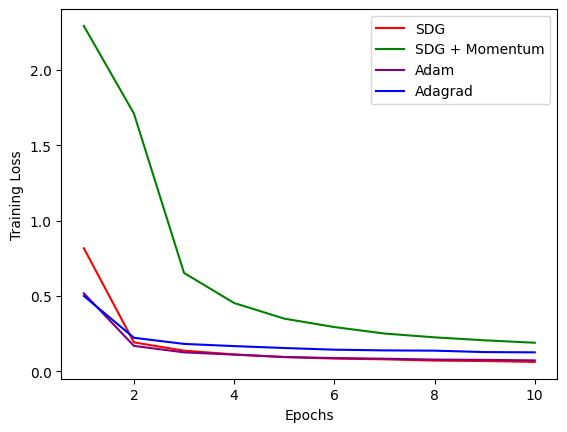

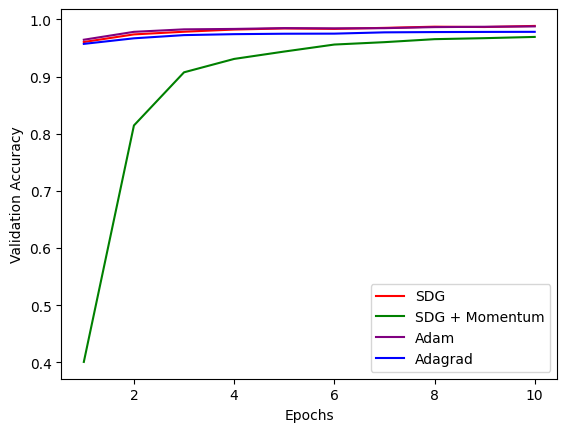

In [18]:

def plot_epochs_vs(cnn: RegularizedNet, y_axis: str, **kwargs):
    history = cnn.history
    x = [e['epoch'] for e in history]
    y = [e[y_axis] for e in history]
    
    plt.plot(x, y, **kwargs)
    plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plot_epochs_vs(cnn, "train_loss", label="SDG", color="red")
plot_epochs_vs(cnn_sgdm, "train_loss", label="SDG + Momentum", color="green")
plot_epochs_vs(cnn_adam, "train_loss", label="Adam", color="purple")
plot_epochs_vs(cnn_ag, "train_loss", label="Adagrad", color="blue")
plt.show()

plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plot_epochs_vs(cnn, "valid_acc", label="SDG", color="red")
plot_epochs_vs(cnn_sgdm, "valid_acc", label="SDG + Momentum", color="green")
plot_epochs_vs(cnn_adam, "valid_acc", label="Adam", color="purple")
plot_epochs_vs(cnn_ag, "valid_acc", label="Adagrad", color="blue")
plt.show()
    

In [19]:
class CNNBatch(nn.Module):
    def __init__(self, dropout = 0.4):
        super(CNNBatch, self).__init__()
        '''Step -- Fill in the architecture'''
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.batch1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.batch2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, stride=2)

        # Fully-connected layers
        self.fc1 = nn.Linear(512, 256)
        self.batch3 = nn.BatchNorm1d(256)
        self.drop = nn.Dropout(dropout)
        self.fc2 = nn.Linear(256, 128)
        self.batch4 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
        

    def forward(self, x):
        '''Step -- Fill in the Forward propagation function'''      
        output = torch.relu(self.batch1(self.conv1(x)))
        output = self.pool1(output)
        output = torch.relu(self.batch2(self.conv2(output)))
        output = self.pool2(output)

        output = output.reshape(-1, 512)
        output = torch.relu(self.batch3(self.fc1(output)))
        output = self.drop(output)
        output = torch.relu(self.batch4(self.fc2(output)))
        output = self.fc3(output)
        output = torch.softmax(output, 1)
        return output


cnn_adam = RegularizedNet(
    module = CNNBatch, 
    criterion=torch.nn.NLLLoss, 
    optimizer = torch.optim.Adam, 
    batch_size=64,
    lr = 0.001, 
    lambda1 = 0, 
    module__dropout = 0.8,
    optimizer__weight_decay = 0.001
)

cnn_adam.fit(X_train, y_train)
y_pred = cnn_adam.predict(X_test)
accuracy_score(y_test, y_pred)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.3159       0.9815        0.0668  11.3852
      2        0.1163       0.9852        0.0506  11.0985
      3        0.1005       0.9852        0.0496  11.1362
      4        0.0895       0.9873        0.0442  11.0477
      5        0.0822       0.9868        0.0458  10.9813
      6        0.0792       0.9881        0.0412  10.9698
      7        0.0727       0.9889        0.0379  11.0792
      8        0.0724       0.9883        0.0399  10.9423
      9        0.0685       0.9887        0.0394  10.8908
     10        0.0666       0.9878        0.0404  10.9348


0.99